In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score

# read data
data = pd.read_csv('./data/Alltitles_labeled.csv')
data.head()

,title,label
0,Epic Games takes on Apple and Google in Austra...,1
1,Java users on macOS 14 running on Apple silico...,1
2,Apple With No AI Looks More Like Coca-Cola Tha...,1
3,"Daily Advice Thread - March 16, 2024",1
4,"Apple opposes ex-ante regulations, similar to ...",1


In [2]:
X = data['title']
y = data['label']
y.value_counts(normalize = True) # check that the distribution of the label

1    0.60665
0    0.39335
Name: label, dtype: float64

In [3]:
# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=22)

### Naive Bayes Model

In [4]:
# Establish a pipeline that focuses on Naive Bayes model:

NBpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

NBpipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english']
}

In [5]:
# Initiatialise GridSearch across different hyperparameters with a 5 fold cross validation
NBgs = GridSearchCV(NBpipe, 
                    param_grid=NBpipe_params, 
                    cv=5,
                    scoring='f1') 

In [6]:
NBgs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english']},
             scoring='f1')

In [7]:
NBgs.best_params_  # identify the best parameters for the countvectorizer in the Naive Bayes model

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

In [8]:
NBgs.score(X_train, y_train)

0.9683860232945091

In [9]:
NBgs.score(X_test, y_test)

0.9498327759197325

The model does not seem to be overfitted.  
A F1 score of 0.95 seems rather decent, let us look at the confusion matrix and other scores

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


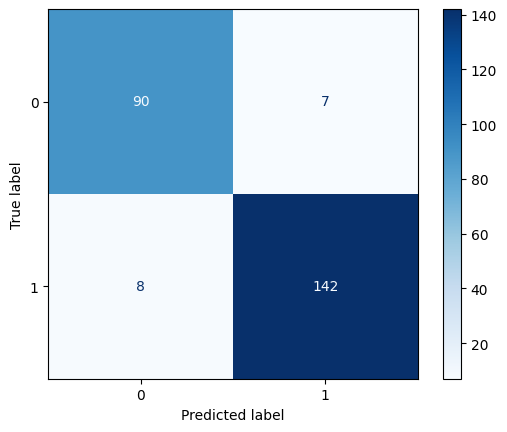

In [10]:
# predict with Naive Bayes Model
NB_pred = NBgs.predict(X_test)

# Save confusion matrix values
NB_tn, NB_fp, NB_fn, NB_tp = confusion_matrix(y_test, NB_pred).ravel()

# Plot confusion matrix
plot_confusion_matrix(NBgs, X_test, y_test, cmap='Blues', values_format='d');

Naive Bayes model seems to be able to classify the Apple subreddit well. The best F1 score looks to be using count vectorizer with the below parameters:  
Maximum features: 2000  
Maximum number of token: 90%  
Minimum number of token: 2  
2-grams
Stop words in English

### Logistic Regression

In [11]:
# Establish a pipeline that focuses on Logistic Regression model:

LRpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

# Search over the following values of hyperparameters:
# the penalty value: 0.1, 1, 10, 100
# the penalty type: l1, l2

LRpipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english'],
    'logreg__C': [0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

In [12]:
LRgs = GridSearchCV(LRpipe, 
                    param_grid=LRpipe_params, 
                    cv=5,
                    scoring='f1',
                    verbose=0) 

In [13]:
LRgs.fit(X_train, y_train)

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'logreg__C': [0.1, 1, 10, 100],
                         'logreg__penalty': ['l1', 'l2']},
             scoring='f1')

In [14]:
LRgs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'logreg__C': 1,
 'logreg__penalty': 'l2'}

In [15]:
LRgs.score(X_train, y_train)

0.9798994974874372

In [16]:
LRgs.score(X_test, y_test)

0.9562289562289563

The model looks better fitted compared to the Naive Bayes, but they have similar F1 score on the testing set

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


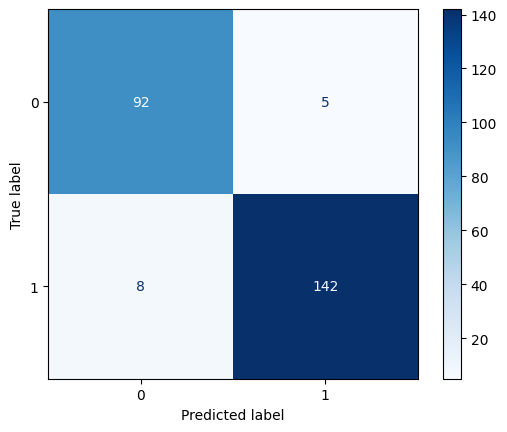

In [17]:
# predict with Logistic Regression Model
LR_pred = LRgs.predict(X_test)

# Save confusion matrix values
LR_tn, LR_fp, LR_fn, LR_tp = confusion_matrix(y_test, LR_pred).ravel()

# Plot confusion matrix
plot_confusion_matrix(LRgs, X_test, y_test, cmap='Blues', values_format='d');

In [18]:
print(f'recall for the Logistic Regression model is {LR_tp/(LR_tp+LR_fn)}')
print(f'precision for the Logistic Regression model is {LR_tp/(LR_tp+LR_fp)}')
print(f'F1 score for the Logistic Regression model is {LRgs.score(X_test, y_test)}')
print('')
print(f'recall for the Naive Bayes model is {NB_tp/(NB_tp+NB_fn)}')
print(f'precision for the Naive Bayes model is {NB_tp/(NB_tp+NB_fp)}')
print(f'F1 score for the Naive Bayes model is {NBgs.score(X_test, y_test)}')

recall for the Logistic Regression model is 0.9466666666666667
precision for the Logistic Regression model is 0.9659863945578231
F1 score for the Logistic Regression model is 0.9562289562289563

recall for the Naive Bayes model is 0.9466666666666667
precision for the Naive Bayes model is 0.9530201342281879
F1 score for the Naive Bayes model is 0.9498327759197325


Despite the above differences in recall and precision across Logistic Regression Model and Naive Bayes Model, they both have similar F1 score in the test set, with Logistic Regression better by 0.65% than Naive Bayse

Since the improvement is not significant, considering the model run time, I have decided to stick with Naive Bayes

To further test out the model's ability in identifying Apple's subreddit, I am going to webscrape a completely different subreddit and put the model to test.  

To also properly replicate the live environment, such random test would not be saved for future re-run. 

### Challenge to the model (Naive Bayes)

In [19]:
import requests
import time

url = 'https://www.reddit.com/r/honeymoonplanning/new.json' # a completely random topic
headers = {'User-agent': 'meehhh'}

titles = []
after = None # a query parameter in the URL, a key to scrape consecutively

# to scrape 30 times
for _ in range(30):
    if after == None:
        params = {}
    else:
        params = {'after': after}
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200: # if successful
        data = res.json()
        for row in data['data']['children']:
            titles.append(row['data']['title']) # to scrape only the title
        after = data['data']['after'] # update query parameter
    else: 
        print(res.status_code)
        break
    time.sleep(2)

random_post = pd.DataFrame(titles)
random_post = random_post.drop_duplicates()
random_post.shape

(742, 1)

In [20]:
random_post['label'] = 0 # label all to 0 as none of the topic belongs to "Apple" subreddit
random_post.columns=['title','label']
random_post.head()

,title,label
0,Honeymoon travel agencies/advisors you’d recom...,0
1,Accessible beachy winter honeymoon destination...,0
2,Honeymoon in Bali,0
3,Island honeymoon,0
4,Honeymoon Australia and Possibly Fiji from NYC,0


The idea is that, if the model is able to generalise well, the model should be able to return most as 0

In [21]:
# assign variables
random_X = random_post['title']
random_y = random_post['label']

In [22]:
# Initiate count vectoriser following the best paramater identified for Naive Bayes model
# fit the vectoriser with the training set that we have
Vector = CountVectorizer(max_df=0.9, min_df=2, max_features=2000, ngram_range=(1, 2), stop_words='english')
Vector.fit(X_train)

# transform the test post
random_X_t = Vector.transform(random_X)

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


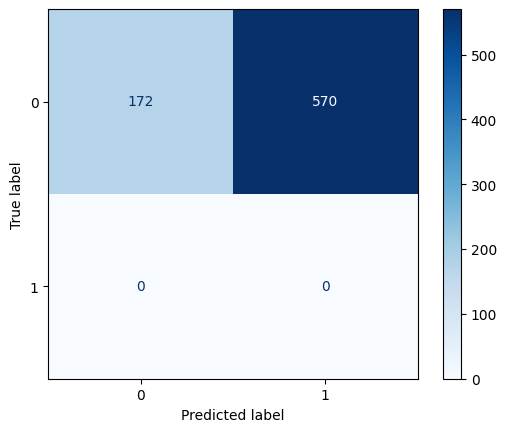

In [23]:
# initialise Naive Bayes
NB = MultinomialNB()

# train the model based on the training data that we have
NB.fit(Vector.transform(X_train), y_train)

# make prediction on test post
plot_confusion_matrix(NB, random_X_t, random_y, cmap='Blues', values_format='d');

Horrible results! The model only manages to identify 23% of the posts that are not from Apple subreddit.  
Let us attempt to find out why

<AxesSubplot: >

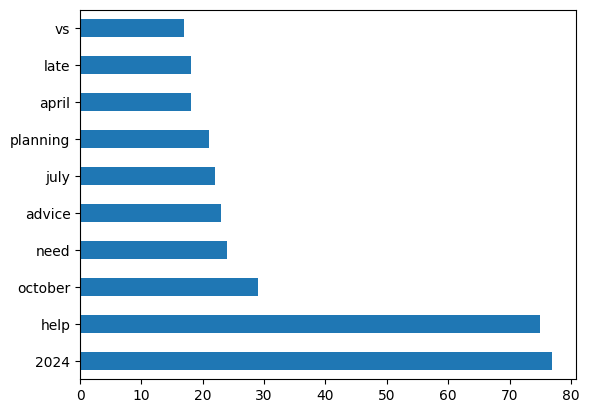

In [24]:
# EDA on random post
test_df = pd.DataFrame(random_X_t.todense(), columns=Vector.get_feature_names_out())
test_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')

It looks like the feature "2024" might be the problem, where we also saw "2024" appears in our training vector under the Apple.  
Let's try to remove the 2024 element and see if the model could offer any improvement

In [25]:
# identify the column location of "2024" in the sparse matrix
origin = Vector.transform(X_train)
origin_df = pd.DataFrame(origin.todense(), columns=Vector.get_feature_names_out())
origin_df.columns.get_loc('2024')

57

In [26]:
# remove the "2024" column (column 57) in the sparse matrix
origin_n2024 = origin[:, [x for x in range(origin.shape[1]) if x != 57]]
origin_n2024

<986x1426 sparse matrix of type '<class 'numpy.int64'>'
	with 7796 stored elements in Compressed Sparse Row format>

In [27]:
# remove the same column in the matrix from random test
random_X_t2 = random_X_t[:, [x for x in range(random_X_t.shape[1]) if x != 57]]
random_X_t2

<742x1426 sparse matrix of type '<class 'numpy.int64'>'
	with 712 stored elements in Compressed Sparse Row format>

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


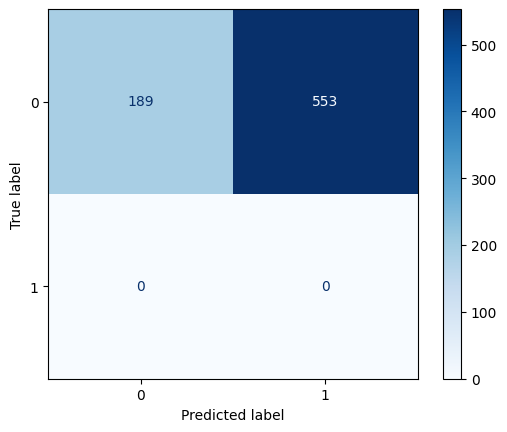

In [28]:
# initialise a new Naive Bayes
NB2 = MultinomialNB()

# train the model using the new sparse matrix without 2024
NB2.fit(origin_n2024, y_train)

# # make prediction on test post
plot_confusion_matrix(NB2, random_X_t2, random_y, cmap='Blues', values_format='d');

The result seems to have improve but it is not significant, from 23% success rate (172/742) to 25% (189/742).  
Let's continue to explore by removing the word "help" as well

In [29]:
origin_df.columns.get_loc('help')

635

In [30]:
# remove the "2024" column (column 57) and "help" (column 635) in the sparse matrix
origin_n2024nhelp = origin[:, [x for x in range(origin.shape[1]) if x not in [57,635]]]
origin_n2024nhelp

<986x1425 sparse matrix of type '<class 'numpy.int64'>'
	with 7789 stored elements in Compressed Sparse Row format>

In [31]:
# remove the same column in the matrix from random test
random_X_t3 = random_X_t[:, [x for x in range(random_X_t.shape[1]) if x not in [57,635]]]
random_X_t3

<742x1425 sparse matrix of type '<class 'numpy.int64'>'
	with 637 stored elements in Compressed Sparse Row format>

C:\Users\heziy\.conda\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


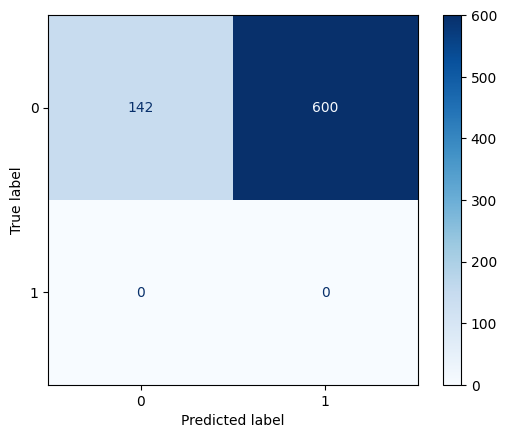

In [32]:
# initialise a new Naive Bayes
NB3 = MultinomialNB()

# train the model using the new sparse matrix without "2024" and "help"
NB3.fit(origin_n2024nhelp, y_train)

# # make prediction on test post
plot_confusion_matrix(NB3, random_X_t3, random_y, cmap='Blues', values_format='d');

It looks like the model cannot be further improve.  
I believe the problem might be from some of the common words that appear in both Apple subreddit and our random post (honeymoon)  
In particular, both the strings "2024" and "advice" seem to appear in both Apple subreddit and our chosen random post  

This might make the model falsely categorise title with these words as belonging to the Apple subreddit. 

### Conclusion and Improvement

Both Naive Bayes and Logistic Regression managed to do binary classification well between Apple and Android subreddit.  
They managed to both achieve at least 95% F1 score in the testing set.  
However, the model seems to perform poorly in data that are not from either Apple and Android subreddit, indicating the model does not generalise well.  

Below factors might contribute to the poor performance in generalisation:  
1. Lack of holistic dataset training  
   Count Vectorizer was only applied to strings data from Apple and Android subreddits, information from other sources have not been considered. The lack fo holistic data limits the model to only accurately classify posts from the either subreddits. One way to improve is to incooprate more data, and attempt multi-class classification, where data can be further distinctively divided.
     
2. Redundent information in the dataset for generalised purpose  
   Data such as the title "Daily Advice Thread" in the Apple subreddit and other numerical values such as date and time might not offer significant values when it comes to generalisation outside the binary classification. One way to improve is probably to remove such redundent data during the exploretary process, but determining redundency posts another challenge and it could lead to data leakage potentially.
     
3. Might just be wrong business problem  
   The whole focus of the project is to identify where a particular title belongs to amongst *TWO* subreddit. It is not to classify any unseen title that is outside of the two subreddits. In order to identify if any titles belong to Apple subreddit, one might need to build a different model that assign a probabilistic value to the unseen title, instead of a binary "yes" or "no". 
     
 